In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch_dct as dct
import time
import requests
from PIL import Image
from io import BytesIO
import torchvision.transforms.functional as F

import sys
import os
root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_path not in sys.path:
    sys.path.insert(0, root_path)
import spectral
from spectral import dct2_2d

Benchmarking on: cuda
Size (N)   | FFT (ms)   | Linear (ms) | Speedup   
--------------------------------------------------
16         | 0.1768     | 0.0119     | 14.88     x
32         | 0.1713     | 0.0179     | 9.55      x
64         | 0.1860     | 0.0136     | 13.72     x
128        | 0.1993     | 0.0137     | 14.57     x
256        | 0.2820     | 0.0188     | 15.03     x
512        | 0.1967     | 0.0193     | 10.22     x
1024       | 0.1875     | 0.0460     | 4.08      x
2048       | 0.2028     | 0.1337     | 1.52      x
4096       | 0.2149     | 0.4747     | 0.45      x


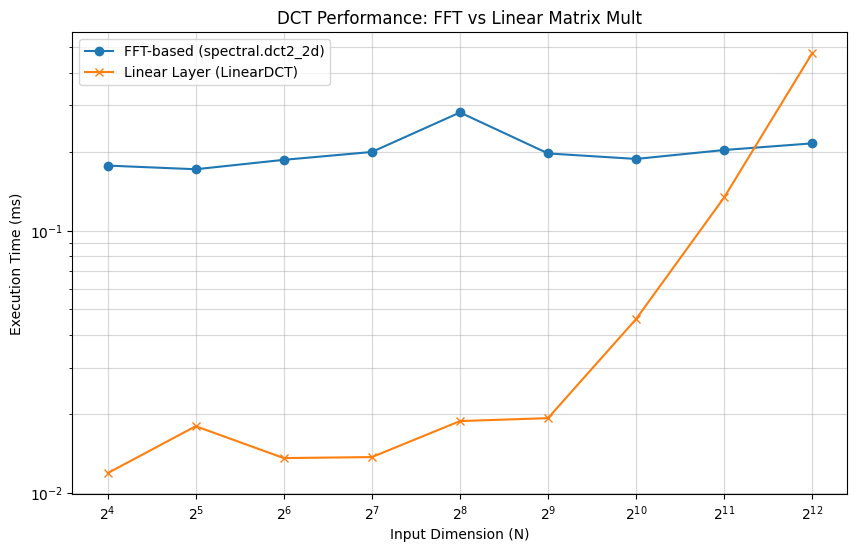

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Benchmarking on: {device}")
sizes = [2**i for i in range(4, 13)] 
batch_size = 128
num_repeats = 100
times_fft = []
times_linear = []

print(f"{'Size (N)':<10} | {'FFT (ms)':<10} | {'Linear (ms)':<10} | {'Speedup':<10}")
print("-" * 50)

for N in sizes:
    x = torch.randn(batch_size, N, device=device)
    for _ in range(10): 
        _ = dct2_2d(x)
    torch.cuda.synchronize() if device.type == 'cuda' else None
    start = time.time()
    for _ in range(num_repeats):
        _ = dct2_2d(x)
    torch.cuda.synchronize() if device.type == 'cuda' else None
    avg_fft = (time.time() - start) / num_repeats * 1000
    linear_layer = dct.LinearDCT(N, type='dct').to(device)
    for _ in range(10):
        _ = linear_layer(x)
    torch.cuda.synchronize() if device.type == 'cuda' else None
    start = time.time()
    for _ in range(num_repeats):
        _ = linear_layer(x)
    torch.cuda.synchronize() if device.type == 'cuda' else None
    avg_linear = (time.time() - start) / num_repeats * 1000
    times_fft.append(avg_fft)
    times_linear.append(avg_linear)
    speedup = avg_fft / avg_linear
    print(f"{N:<10} | {avg_fft:<10.4f} | {avg_linear:<10.4f} | {speedup:<10.2f}x")

plt.figure(figsize=(10, 6))
plt.plot(sizes, times_fft, label='FFT-based (spectral.dct2_2d)', marker='o')
plt.plot(sizes, times_linear, label='Linear Layer (LinearDCT)', marker='x')
plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel('Input Dimension (N)')
plt.ylabel('Execution Time (ms)')
plt.title('DCT Performance: FFT vs Linear Matrix Mult')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.show()